In [1]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 31.00 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [2]:
## unzip archives  q - quite, n - don't overwrite
!unzip -q -n '/content/COVID-CT/Images-processed/CT_COVID.zip'
!unzip -q -n '/content/COVID-CT/Images-processed/CT_NonCOVID.zip'

In [3]:
import os
path='/content/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid Positive cases:  348
Covid Negative cases:  396


In [4]:
base_dir = '/content/covid19_CT'
if not os.path.exists(base_dir): os.mkdir(base_dir)

In [5]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):os.mkdir(test_dir)

In [6]:
original_dataset_dir_covid = '/content/CT_COVID/'
original_dataset_dir_non_covid = '/content/CT_NonCOVID/'

import shutil
fnames = ['covid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['covid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['covid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [7]:
fnames = ['noncovid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [8]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [9]:
def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0

In [10]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [11]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(500, 224, 224, 3)
(100, 224, 224, 3)
(96, 224, 224, 3)


In [12]:
## DenseNet121

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [13]:
model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000
)
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

In [14]:
for layer in model.layers[:int(len(model.layers) / 2)]:
    layer.trainable = False

outt = model(img_input, training=False)

x = Flatten()(outt)
out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes

model = Model(img_input, out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 50177     
Total params: 7,087,681
Trainable params: 4,682,049
Non-trainable params: 2,405,632
_________________________________________________________________


In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='model.h5', save_best_only=True)
]

In [17]:
history = model.fit(train_X, train_y,
                              batch_size=20,
                              epochs=100,
                              validation_data=(val_X, val_y),
                              callbacks=my_callbacks)

Epoch 1/100
25/25 [==============================] - 50s 380ms/step - loss: 1.7494 - acc: 0.4920 - val_loss: 0.7399 - val_acc: 0.5000
Epoch 2/100
25/25 [==============================] - 7s 289ms/step - loss: 0.6776 - acc: 0.5760 - val_loss: 0.6429 - val_acc: 0.6400
Epoch 3/100
25/25 [==============================] - 7s 290ms/step - loss: 0.5646 - acc: 0.7120 - val_loss: 0.5326 - val_acc: 0.6900
Epoch 4/100
25/25 [==============================] - 8s 311ms/step - loss: 0.4752 - acc: 0.7820 - val_loss: 0.5523 - val_acc: 0.7200
Epoch 5/100
25/25 [==============================] - 7s 288ms/step - loss: 0.9390 - acc: 0.8040 - val_loss: 2.3606 - val_acc: 0.5000
Epoch 6/100
25/25 [==============================] - 8s 309ms/step - loss: 1.5918 - acc: 0.6200 - val_loss: 0.5229 - val_acc: 0.7600
Epoch 7/100
25/25 [==============================] - 7s 287ms/step - loss: 0.4534 - acc: 0.8140 - val_loss: 0.4910 - val_acc: 0.8200
Epoch 8/100
25/25 [==============================] - 7s 289ms/step -

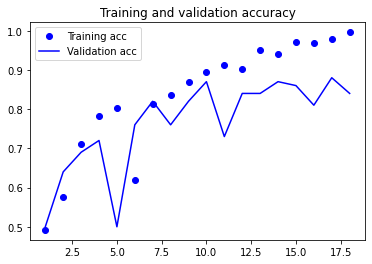

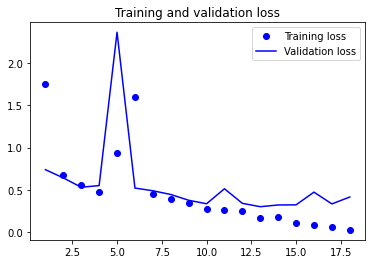

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9959999918937683
Val Accuracy:	 0.8399999737739563
Test Accuracy:	 0.84375
Precision:	 0.851063829787234
Recall:		 0.8333333333333334
F1 Score:	 0.8421052631578947
AUC:		 0.84375


In [20]:
# code taken from lab
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    conf_mat: confusion matrix
    classes: names of classes to be annotated
    normalize: [True/False] whether to normalise by column
    """
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


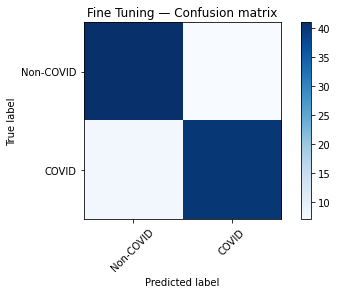

In [21]:
cnf_matrix = confusion_matrix(test_y, ypred)
plot_confusion_matrix(cnf_matrix, classes=['Non-COVID', 'COVID'], normalize=False,
                      title='Fine Tuning — Confusion matrix')